In this exercise, you'll unleash the hidden creativity of your computer, by letting it generate Country songs (yeehaw!). You'll train a character-level RNN-based language model, and use it to generate new songs.


### Special Note

Our Deep Learning course was packed with both theory and practice. In a short time, you've got to learn the basics of deep learning theory and get hands-on experience training and using pretrained DL networks, while learning PyTorch.  
Past exercises required a lot of work, and hopefully gave you a sense of the challenges and difficulties one faces when using deep learning in the real world. While the investment you've made in the course so far is enormous, We strongly encourage you to take a stab at this exercise. 

Some songs contain no lyrics (for example, they just contain the text "instrumental"). Others include non-English characters. You'll often need to preprocess your data and make decisions as to what your network should actually get as input (think - how should you treat newline characters?)

More issues will probably pop up while you're working on this task. If you face technical difficulties or find a step in the process that takes too long, please let me know. It would also be great if you share with the class code you wrote that speeds up some of the work (for example, a data loader class, a parsed dataset etc.)

## RNN for Text Generation
In this section, we'll use an LSTM to generate new songs. You can pick any genre you like, or just use all genres. You can even try to generate songs in the style of a certain artist - remember that the Metrolyrics dataset contains the author of each song. 

For this, we’ll first train a character-based language model. We’ve mostly discussed in class the usage of RNNs to predict the next word given past words, but as we’ve mentioned in class, RNNs can also be used to learn sequences of characters.

First, please go through the [PyTorch tutorial](https://pytorch.org/tutorials/intermediate/char_rnn_generation_tutorial.html) on generating family names. You can download a .py file or a jupyter notebook with the entire code of the tutorial. 

As a reminder of topics we've discussed in class, see Andrej Karpathy's popular blog post ["The Unreasonable Effectiveness of Recurrent Neural Networks"](http://karpathy.github.io/2015/05/21/rnn-effectiveness/). You are also encouraged to view [this](https://gist.github.com/karpathy/d4dee566867f8291f086) vanilla implementation of a character-level RNN, written in numpy with just 100 lines of code, including the forward and backward passes.  

Other tutorials that might prove useful:
1. http://warmspringwinds.github.io/pytorch/rnns/2018/01/27/learning-to-generate-lyrics-and-music-with-recurrent-neural-networks/
1. https://github.com/mcleonard/pytorch-charRNN
1. https://github.com/spro/practical-pytorch/blob/master/char-rnn-generation/char-rnn-generation.ipynb

### Final Tips
As a final tip, we do encourage you to do most of the work first on your local machine. They say that Data Scientists spend 80% of their time cleaning the data and preparing it for training (and 20% complaining about cleaning the data and preparing it). Handling these parts on your local machine usually mean you will spend less time complaining. You can switch to the cloud once your code runs and your pipeline is in place, for the actual training using a GPU.  

We also encourage you to use a small subset of the dataset first, so things run smoothly. The Metrolyrics dataset contains over 300k songs. You can start with a much much smaller set (even 3,000 songs) and try to train a network based on it. Once everything runs properly, add more data. 

Good luck!  

---
#### This exericse was originally written by Dr. Omri Allouche.

# Solution

 The solution based on the first tutorial: 
 http://warmspringwinds.github.io/pytorch/rnns/2018/01/27/learning-to-generate-lyrics-and-music-with-recurrent-neural-networks/

## Imports

In [1]:
!pip install BeautifulSoup4
!pip install --upgrade gensim
!pip install tqdm
!pip install langdetect

     |████████████████████████████████| 24.1 MB 338 kB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0
     |████████████████████████████████| 981 kB 7.6 MB/s 
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993242 sha256=f773bd762c0c93d7ed509a6cc270b5a40a6f7b8efae9adc2d10970cff9bcb2a8
  Stored in directory: /root/.cache/pip/wheels/c5/96/8a/f90c59ed25d75e50a8c10a1b1c2d4c402e4dacfa87f3aff36a
Successfully built langdetect


In [3]:
import nltk
nltk.download("stopwords")
nltk.download('punkt') #for tokenize

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch, time, copy, os, re, zipfile, string
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
from torch.optim import lr_scheduler
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader, TensorDataset
from nltk.corpus import stopwords # Import the stop word list
from bs4 import BeautifulSoup
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from nltk.tokenize.treebank import TreebankWordDetokenizer #convert back to sentence
import warnings
warnings.filterwarnings('ignore')
from langdetect import detector_factory, detect
from torch.autograd import Variable

## Research input lyrics

In [5]:
songs_df = pd.read_parquet('/content/metrolyrics.parquet')

In [6]:
songs_df.iloc[0].lyrics

"[HEALY]\n[spoken] This is Bert Healy saying ...\n[singing now] Hey, hobo man\nHey, Dapper Dan\nYou've both got your style\nBut Brother,\nYou're never fully dressed\nWithout a smile!\nYour clothes may be Beau Brummelly\nThey stand out a mile --\nBut Brother,\nYou're never fully dressed\nWithout a smile!\nWho cares what they're wearing\nOn Main Street,\nOr Saville Row,\nIt's what you wear from ear to ear\nAnd not from head to toe\n(That matters)\nSo, Senator,\nSo, Janitor,\nSo long for a while\nRemember,\nYou're never fully dressed\nWithout a smile!\n[BOYLAN SISTER]\nReady or not, here he goes\nListen to Bert\nTap his smilin' toes\n[HEALY]\n[spoken] Ah, the lovely Boylan Sisters\n[BOYLAN SISTERS]\nDoo doodle-oo doo\nDoo doodle-oo doo\nDoo doo doo doo\nDoo doo doo doo\nYour clothes may be Beau Brummelly\nThey stand out a mile\nBut, bother\nYou're never fully dressed\nYou're never dressed\nWithout an\n[CONNIE BOYLAN]\nS-\n[BONNIE BOYLAN]\nM-\n[RONNIE BOYLAN]\nI-\n[CONNIE BOYLAN]\nL-\n[ALL

In [7]:
songs_df.loc[songs_df['lyrics'].str.contains('no lyrics')]

,song,year,artist,genre,lyrics,num_chars,sent,num_words
63842,the-ballad-of-32,1984,frankie-goes-to-hollywood,Pop,"Sorry, there is no lyrics for Ballad of 32 by ...",181,sorry lyrics ballad fgth sexy instrumental son...,96
188684,when-winter-comes,2007,chris-de-burgh,Rock,"This is instrumental. It has no lyrics, only a...",132,this instrumental it lyrics voice end sings al...,76
196645,like-swimming,2008,foals,Rock,NOTE:\nThere are no lyrics to this song.\nThe ...,122,note there lyrics song the whole song intro ne...,71
59059,case-closed,2006,cypress-hill,Hip-Hop,Motherfucker with one little single\nThree or ...,2152,motherfucker one little single three four camm...,1444


In [8]:
songs_df.loc[(songs_df['lyrics'].str.contains('instrumental')) & (songs_df['num_words'] <100)]

,song,year,artist,genre,lyrics,num_chars,sent,num_words
63842,the-ballad-of-32,1984,frankie-goes-to-hollywood,Pop,"Sorry, there is no lyrics for Ballad of 32 by ...",181,sorry lyrics ballad fgth sexy instrumental son...,96
241800,the-pacifier,2006,elton-john,Rock,Written by elton john\nAvailable on the variou...,101,written elton john available various artists a...,79
188684,when-winter-comes,2007,chris-de-burgh,Rock,"This is instrumental. It has no lyrics, only a...",132,this instrumental it lyrics voice end sings al...,76


**As we can see, there are some fixes we need to do in lyrics:**
1. Words in square brackets are mostly represent notes and not lyrics, for example: [singing now], [spoke] ...
2. The \n are from html and we need to remove it because it doesn't represent any valid word
3. Special marks are not relevant
4. There are texts without lyrics, we saw that those text has less than 100 words (in average) and as mentioned before mostly contains the words 'instrumental' or 'no lyrics. we will drop those records.
5. Drop non english lyrics because most of the texts are in english

## Preprocess input lyrics

In [9]:
def drop_non_lyrics(df):
  no_lyrics_cond1 = (df['lyrics'].str.contains('no lyrics')) & (df['num_words'] <100)
  no_lyrics_cond2 = (df['lyrics'].str.contains('instrumental')) & (df['num_words'] <100)
  df = df.loc[~(no_lyrics_cond1 | no_lyrics_cond2)]
  return df

def preprocess_lyrics(lyrics):
  clean_lyrics = re.sub("[\(\[].'*?[\)\]]", " ", lyrics) #drop square brackets
  clean_lyrics = clean_lyrics.replace('\n', ' ') #drop \n
  clean_lyrics = re.sub(r'\s*\d+\s*', ' ', clean_lyrics) #drop digits
  clean_lyrics = re.sub(r'[^\w\s]', '', clean_lyrics) #drop special marks
  clean_lyrics = re.sub(' +', ' ', clean_lyrics) #fix spaces
  return clean_lyrics

detector_factory.seed = 42
def get_lyrics_language(lyrics):
    language = detector_factory.detect_langs(lyrics)[0]
    if language.prob > 0.6:
      return language.lang
    else:
      return 'unknown'

In [77]:
country_df = songs_df.loc[songs_df['genre'] == 'Country']
country_df = drop_non_lyrics(country_df)
country_df['clean_lyrics'] = country_df['lyrics'].apply(lambda x: preprocess_lyrics(x))
country_df['language'] = country_df['clean_lyrics'].apply(lambda x: get_lyrics_language(x))
country_df = country_df.loc[country_df['language'] == 'en']

# Limit lyrics to max length of 3000 on long inputs- brings the best results
country_df = country_df[(country_df.clean_lyrics.str.len() <= 3000)]

In [78]:
country_df.head()

,song,year,artist,genre,lyrics,num_chars,sent,num_words,clean_lyrics,language
127800,the-last-goodbye,2008,aaron-pritchett,Country,Sprintime in Savannah\nIt dont get much pretti...,881,sprintime savannah it dont get much prettier b...,639,Sprintime in Savannah It dont get much prettie...,en
963,wherever-is-your-heart,2015,brandi-carlile,Country,I think it's time we found a way back home\nYo...,1635,i think time found way back home you loose man...,1196,I think its time we found a way back home You ...,en
216996,tree-of-hearts,2006,bryan-white,Country,On a tree inside a heart\nA dull boyscout knif...,1193,on tree inside heart a dull boyscout knife too...,873,On a tree inside a heart A dull boyscout knife...,en
159985,fireworks,2008,caitlin-cary,Country,"Oh, when you're leaving for the hundredth time...",1051,oh leaving hundredth time day looking reason r...,664,Oh when youre leaving for the hundredth time o...,en
133958,i-can-get-by,2007,clint-black,Country,In a simple life dreams die hard\nYou never le...,1437,in simple life dreams die hard you never let e...,907,In a simple life dreams die hard You never let...,en


## Create dataset

In [79]:
class MyDatatset(Dataset):
    def __init__(self, songs_lyrics_list, max_chars_lyrics, all_characters):
        self.songs_lyrics_list = songs_lyrics_list
        self.all_characters = all_characters
        self.max_chars_lyrics = max_chars_lyrics # for padding
        self.input_pad = 100
        self.output_pad = -100

    # Find letter index from all_letters, e.g. "a" = 0
    def letter_to_index(self, letter):
        letter_index = self.all_characters.find(letter)
        if letter_index == -1:
          letter_index = None
        return letter_index

    # Turn a line into vector of indexes
    def lyrics_to_index_vec(self, lyrics):
      lyrics_indexes = []
      for li, letter in enumerate(list(lyrics)):
          index = self.letter_to_index(letter)
          if index:
            lyrics_indexes.append(self.letter_to_index(letter))
      return lyrics_indexes

    def pad_sequence(self, indexes_vec, max_length, pad_label):
      indexes_vec += [pad_label for i in range(max_length - len(indexes_vec))]
      return indexes_vec

    def __getitem__(self, item):
        lyrics = self.songs_lyrics_list[item]
        lyrics_length = len(list(lyrics)) - 1
        lyrics_labels_indexes = self.lyrics_to_index_vec(lyrics)

        # Shifted by one char
        input_lyrics_labels = lyrics_labels_indexes[:-1] # all inputs except last one
        output_lyrics_labels = lyrics_labels_indexes[1:] # all outputs except first one

        input_string_labels_padded = self.pad_sequence(input_lyrics_labels, max_length=self.max_chars_lyrics, pad_label=self.input_pad)
        output_string_labels_padded = self.pad_sequence(output_lyrics_labels, max_length=self.max_chars_lyrics, pad_label=self.output_pad)
        
        return (torch.LongTensor(input_string_labels_padded),
                torch.LongTensor(output_string_labels_padded),
                torch.LongTensor([lyrics_length]) )

    def __len__(self):
        return len(self.songs_lyrics_list)

In [80]:
def post_process_sequence_batch(batch_tuple):
    
    input_sequences, output_sequences, lengths = batch_tuple
    
    # split to tuple of matrix rows each row is lyrics
    splitted_input_sequence_batch = input_sequences.split(split_size=1)
    splitted_output_sequence_batch = output_sequences.split(split_size=1)
    splitted_lengths_batch = lengths.split(split_size=1)

    # zip to tuples of input line, output line, length
    training_data_tuples = zip(splitted_input_sequence_batch,
                               splitted_output_sequence_batch,
                               splitted_lengths_batch)

    training_data_tuples_sorted = sorted(training_data_tuples, key=lambda p: int(p[2]), reverse=True) # sort by length 

    splitted_input_sequence_batch, splitted_output_sequence_batch, splitted_lengths_batch = zip(*training_data_tuples_sorted) # unzip

    # reduce dim to get matrixes
    input_sequence_batch_sorted = torch.cat(splitted_input_sequence_batch)
    output_sequence_batch_sorted = torch.cat(splitted_output_sequence_batch)
    lengths_batch_sorted = torch.cat(splitted_lengths_batch)

    # concat the padding area to be from the same len of the longest lyrics
    input_sequence_batch_sorted = input_sequence_batch_sorted[:, :lengths_batch_sorted[0, 0]]
    output_sequence_batch_sorted = output_sequence_batch_sorted[:, :lengths_batch_sorted[0, 0]]

    # switch rows to columns, each row is lyrics
    input_sequence_batch_transposed = input_sequence_batch_sorted.transpose(0, 1)
    
    # pytorch's api for rnns wants lenghts to be list of ints
    lengths_batch_sorted_list = list(lengths_batch_sorted)
    lengths_batch_sorted_list = [int(x) for x in lengths_batch_sorted_list]
    
    return input_sequence_batch_transposed, output_sequence_batch_sorted, lengths_batch_sorted_list

## Create RNN

In [81]:
class RNN(nn.Module):
    
    def __init__(self, input_size, hidden_size, num_classes, n_layers=2):
        super(RNN, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_classes = num_classes
        self.n_layers = n_layers
                
        # input_size -- size of the dictionary + 1 (accounts for padding constant)
        self.encoder = nn.Embedding(input_size, hidden_size)
        
        self.lstm = nn.LSTM(hidden_size, hidden_size, n_layers)
        
        self.logits_fc = nn.Linear(hidden_size, num_classes)
    
    
    def forward(self, input_sequences, input_sequences_lengths, hidden=None):
        batch_size = input_sequences.shape[1]
        embedded = self.encoder(input_sequences).to(device)

        # Here we run rnns only on non-padded regions of the batch
        packed = torch.nn.utils.rnn.pack_padded_sequence(embedded, input_sequences_lengths)
        outputs, hidden = self.lstm(packed, hidden)
        outputs, output_lengths = torch.nn.utils.rnn.pad_packed_sequence(outputs) # unpack (back to padded)
        
        logits = self.logits_fc(outputs)
        logits = logits.transpose(0, 1).contiguous()
        logits_flatten = logits.view(-1, self.num_classes)
        
        return logits_flatten, hidden

## Train model on small dataset

In [82]:
all_characters = string.printable

In [83]:
small_dataset = country_df.head(1500)

max_chars_lyrics = small_dataset.clean_lyrics.str.len().max()
songs_lyrics_small_list = small_dataset['clean_lyrics'].to_list()

small_train_lyrics_list, small_test_lyrics_list = train_test_split(songs_lyrics_small_list, test_size=0.2, random_state=42)

small_trainset = MyDatatset(small_train_lyrics_list, max_chars_lyrics, all_characters)
small_testset = MyDatatset(small_test_lyrics_list, max_chars_lyrics, all_characters)

small_dataloaders = {
    'train': torch.utils.data.DataLoader(small_trainset, batch_size=32, shuffle=True, num_workers=4),
    'val': torch.utils.data.DataLoader(small_testset, batch_size=32, shuffle=False, num_workers=4)
  }

small_dataset_sizes = {x: len(small_dataloaders[x].dataset) for x in ['train', 'val']}
print('dataset_sizes: ', small_dataset_sizes)

dataset_sizes:  {'train': 1200, 'val': 300}


In [84]:
input, output, lengths = next(iter(small_dataloaders['train']))
print(f'Input shape: {input.shape}, Sample: {input[0]}')
print(f'Output shape: {output.shape} Sample: {output[0]}')
print(f'Lengths shape: {lengths.shape} Sample: {lengths[0]}')

Input shape: torch.Size([32, 2966]), Sample: tensor([ 44,  15,  94,  ..., 100, 100, 100])
Output shape: torch.Size([32, 2966]) Sample: tensor([  15,   94,   22,  ..., -100, -100, -100])
Lengths shape: torch.Size([32, 1]) Sample: tensor([518])


In [85]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
CUDA_LAUNCH_BLOCKING=1
device

device(type='cuda', index=0)

In [86]:
torch.cuda.empty_cache()

In [87]:
sample_rnn_model = RNN(input_size=len(all_characters) + 1, hidden_size=512, num_classes=len(all_characters)).to(device)
sample_rnn_model

RNN(
  (encoder): Embedding(101, 512)
  (lstm): LSTM(512, 512, num_layers=2)
  (logits_fc): Linear(in_features=512, out_features=100, bias=True)
)

In [88]:
criterion = nn.CrossEntropyLoss()

# Use Stochastic Gradient Descent as the optimizer, with a learning rate of 0.0001 and momentum
optimizer_ft = torch.optim.Adam(sample_rnn_model.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

num_epochs = 10

In [89]:
def train_model(model, dataloaders, criterion, optimizer, scheduler, dataset_sizes, num_epochs=25):
    since = time.time()

    # Init variables that will save info about the best model
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = np.inf
    results = {'train_loss': [], 'test_loss': []}

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                # Set model to training mode. 
                model.train()
            else:
                # Set model to evaluate mode. In evaluate mode, we don't perform backprop and don't need to keep the gradients
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            # for inputs, labels in dataloaders[phase]:
            for batch in dataloaders[phase]:
                post_processed_batch_tuple = post_process_sequence_batch(batch)
                input_sequences_batch, output_sequences_batch, sequences_lengths = post_processed_batch_tuple

                # Prepare the inputs for GPU/CPU
                inputs = input_sequences_batch.long().to(device)
                outputs = output_sequences_batch.contiguous().view(-1).long().to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # ===== forward pass ======
                with torch.set_grad_enabled(phase=='train'):
                    # If we're in train mode, we'll track the gradients to allow back-propagation
                    logits, _ = model(inputs, sequences_lengths) # apply the model to the inputs.
                    _, preds = torch.max(logits, 1) #the max probability from each row place 
                    loss = criterion(logits, outputs)

                    # ==== backward pass + optimizer step ====
                    # This runs only in the training phase
                    if phase == 'train':
                        loss.backward() # Perform a step in the opposite direction of the gradient
                        optimizer.step() # Adapt the optimizer

                # Collect statistics
                running_loss += loss.item() * inputs.size(0)
                

            epoch_loss = running_loss / dataset_sizes[phase]

            if phase == 'train':
                # Adjust the learning rate based on the scheduler
                scheduler.step()
                results['train_loss'].append(epoch_loss)            
            else:
                results['test_loss'].append(epoch_loss)

            print(f'{phase} Loss: {epoch_loss:.4f}')

            # Keep the results of the best model so far
            if phase == 'val' and epoch_loss < best_loss:
                best_loss = epoch_loss
                # deepcopy the model
                best_model_wts = copy.deepcopy(model.state_dict())
        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {(time_elapsed // 60):.0f}m {(time_elapsed % 60):.0f}s')
    print(f'Best val loss: {best_loss:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, results

In [90]:
sample_rnn_model, results_small_data = train_model(sample_rnn_model, small_dataloaders, criterion, optimizer_ft, 
                                                   exp_lr_scheduler, small_dataset_sizes, num_epochs)

Epoch 0/9
----------
train Loss: 173.6215
val Loss: 137.7524

Epoch 1/9
----------
train Loss: 133.6338
val Loss: 118.6152

Epoch 2/9
----------
train Loss: 117.8198
val Loss: 108.2047

Epoch 3/9
----------
train Loss: 109.0396
val Loss: 101.9857

Epoch 4/9
----------
train Loss: 104.2405
val Loss: 97.5539

Epoch 5/9
----------
train Loss: 101.2722
val Loss: 94.3383

Epoch 6/9
----------
train Loss: 95.5820
val Loss: 92.0944

Epoch 7/9
----------
train Loss: 93.8166
val Loss: 90.8983

Epoch 8/9
----------
train Loss: 94.5166
val Loss: 90.5918

Epoch 9/9
----------
train Loss: 92.8967
val Loss: 90.3036

Training complete in 3m 24s
Best val loss: 90.303647


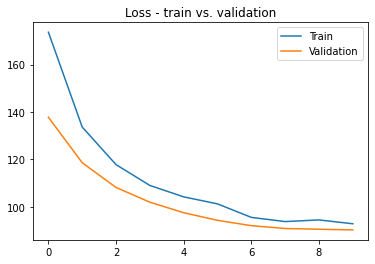

In [91]:
plt.plot(results_small_data['train_loss'], label="Train")
plt.plot(results_small_data['test_loss'], label= "Validation")
plt.legend()
plt.title('Loss - train vs. validation')
plt.show()

In [92]:
def index_to_letter(index):
  letter = all_characters.find(index)
  return letter

def string_to_labels(character_string):
    return [index_to_letter(char_index) for char_index in character_string]

def sample_from_rnn(rnn, start_str="Why", sample_length=300, temperature=1):
    sampled_string = start_str
    hidden = None

    first_input = torch.LongTensor(string_to_labels(sampled_string)).cuda()
    first_input = first_input.unsqueeze(1)
    current_input = Variable(first_input)

    output, hidden = rnn(current_input, [len(sampled_string)], hidden=hidden)

    output = output[-1, :].unsqueeze(0)

    for i in range(sample_length):

        output_dist = nn.functional.softmax( output.view(-1).div(temperature)).data

        predicted_label = torch.multinomial(output_dist, 1)

        sampled_string += all_characters[int(predicted_label[0])]

        current_input = Variable(predicted_label.unsqueeze(1))

        output, hidden = rnn(current_input, [1], hidden=hidden)
    
    return sampled_string

In [93]:
print(sample_from_rnn(sample_rnn_model, start_str="Where", sample_length=100, temperature=0.5))

Where the way the still be the still see I was could never mean the country your could can really for the


## Train model on entire dataset

In [94]:
all_characters = string.printable

In [95]:
max_chars_lyrics = country_df.clean_lyrics.str.len().max()
songs_lyrics_list = country_df['clean_lyrics'].to_list()

train_lyrics_list, test_lyrics_list = train_test_split(songs_lyrics_list, test_size=0.2, random_state=42)

trainset = MyDatatset(train_lyrics_list, max_chars_lyrics, all_characters)
testset = MyDatatset(test_lyrics_list, max_chars_lyrics, all_characters)

dataloaders = {'train': torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True, num_workers=4),
               'val': torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False, num_workers=4)}

dataset_sizes = {x: len(dataloaders[x].dataset) for x in ['train', 'val']}
print('dataset_sizes: ', dataset_sizes)

dataset_sizes:  {'train': 6580, 'val': 1645}


In [96]:
input, output, lengths = next(iter(dataloaders['train']))
print(f'Input shape: {input.shape}, Sample: {input[0]}')
print(f'Output shape: {output.shape} Sample: {output[0]}')
print(f'Lengths shape: {lengths.shape} Sample: {lengths[0]}')

Input shape: torch.Size([32, 2966]), Sample: tensor([ 47,  18,  20,  ..., 100, 100, 100])
Output shape: torch.Size([32, 2966]) Sample: tensor([  18,   20,   14,  ..., -100, -100, -100])
Lengths shape: torch.Size([32, 1]) Sample: tensor([554])


In [97]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
CUDA_LAUNCH_BLOCKING=1
device

device(type='cuda', index=0)

In [98]:
torch.cuda.empty_cache()

In [99]:
rnn_model = RNN(input_size=len(all_characters) + 1, hidden_size=512, num_classes=len(all_characters)).to(device)
rnn_model

RNN(
  (encoder): Embedding(101, 512)
  (lstm): LSTM(512, 512, num_layers=2)
  (logits_fc): Linear(in_features=512, out_features=100, bias=True)
)

In [100]:
criterion = nn.CrossEntropyLoss()

# Use Stochastic Gradient Descent as the optimizer, with a learning rate of 0.0001 and momentum
optimizer_ft = torch.optim.Adam(rnn_model.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

num_epochs = 10

In [101]:
rnn_model, results= train_model(rnn_model, dataloaders, criterion, optimizer_ft, 
                                exp_lr_scheduler, dataset_sizes, num_epochs)

Epoch 0/9
----------
train Loss: 120.4110
val Loss: 98.4411

Epoch 1/9
----------
train Loss: 88.9963
val Loss: 87.6911

Epoch 2/9
----------
train Loss: 82.3617
val Loss: 83.5463

Epoch 3/9
----------
train Loss: 79.3481
val Loss: 81.0637

Epoch 4/9
----------
train Loss: 76.7782
val Loss: 79.4025

Epoch 5/9
----------
train Loss: 75.7488
val Loss: 78.0801

Epoch 6/9
----------
train Loss: 74.4966
val Loss: 76.8268

Epoch 7/9
----------
train Loss: 72.3326
val Loss: 75.3180

Epoch 8/9
----------
train Loss: 71.6123
val Loss: 75.1747

Epoch 9/9
----------
train Loss: 70.9972
val Loss: 75.0224

Training complete in 17m 53s
Best val loss: 75.022354


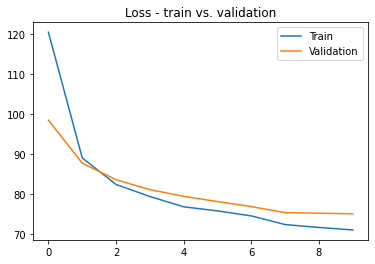

In [102]:
plt.plot(results['train_loss'], label="Train")
plt.plot(results['test_loss'], label= "Validation")
plt.legend()
plt.title('Loss - train vs. validation')
plt.show()

In [103]:
print(sample_from_rnn(rnn_model, start_str="Where", sample_length=100, temperature=0.5))

Where the light is just to see the wind of the dark I was a beautiful tears of my mind With all the night


In [104]:
print(sample_from_rnn(rnn_model, start_str="Good", sample_length=100, temperature=0.5))

Good to the line I got a little hand of my heart And I was an old heart in the past in the door In the d


In [105]:
print(sample_from_rnn(rnn_model, start_str="Hello", sample_length=100, temperature=0.5))

Hello Oh I was a party started time to stay away I pray the best thing I can see the light of the hill Th
